## 3(2) Feature_Transformation&Selection_1015
221015에 생성한 Feature를 변환, 선택하는 파일이다.

### Import

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import warnings ; warnings.filterwarnings('ignore')

### Read Data

In [2]:
train = pd.read_csv('../data/feature/20221015_train.csv')
test = pd.read_csv('../data/feature/20221015_test.csv')
train_raw, test_raw = train.copy(), test.copy()

In [3]:
# Feature가 아닌 변수를 제거한다.
del train['id'], test['id']

# X_train, y_train, X_test를 지정한다
y_train = train['target'] ; del train['target']
X_train, X_test = train, test
print('X_train.shape:', X_train.shape, 'X_test.shape', X_test.shape)

X_train.shape: (4701217, 47) X_test.shape (291241, 47)


### $\blacktriangleright$ Feature Transform

In [4]:
cat = ['day_of_week', 'road_rating','multi_linked', 'connect_code', 'maximum_speed_limit',
       'weight_restricted', 'road_type', 'start_turn_restricted', 'end_turn_restricted']
num = [i for i in X_train.columns if i not in cat]

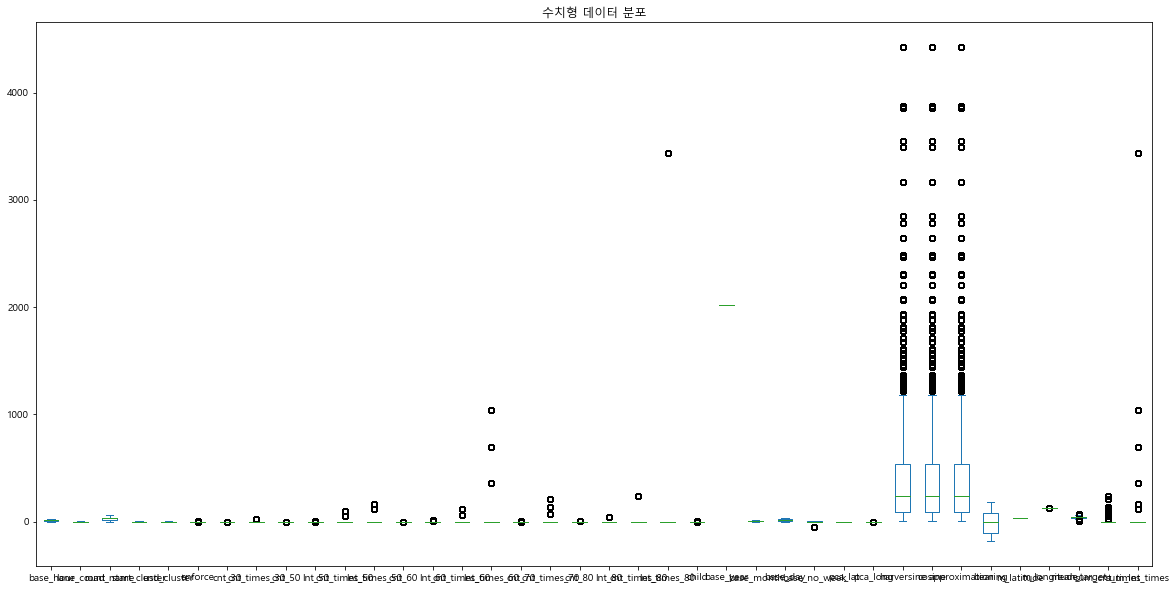

In [5]:
X_train.loc[:,num].plot.box(title="수치형 데이터 분포", figsize=(20,10))
plt.show()

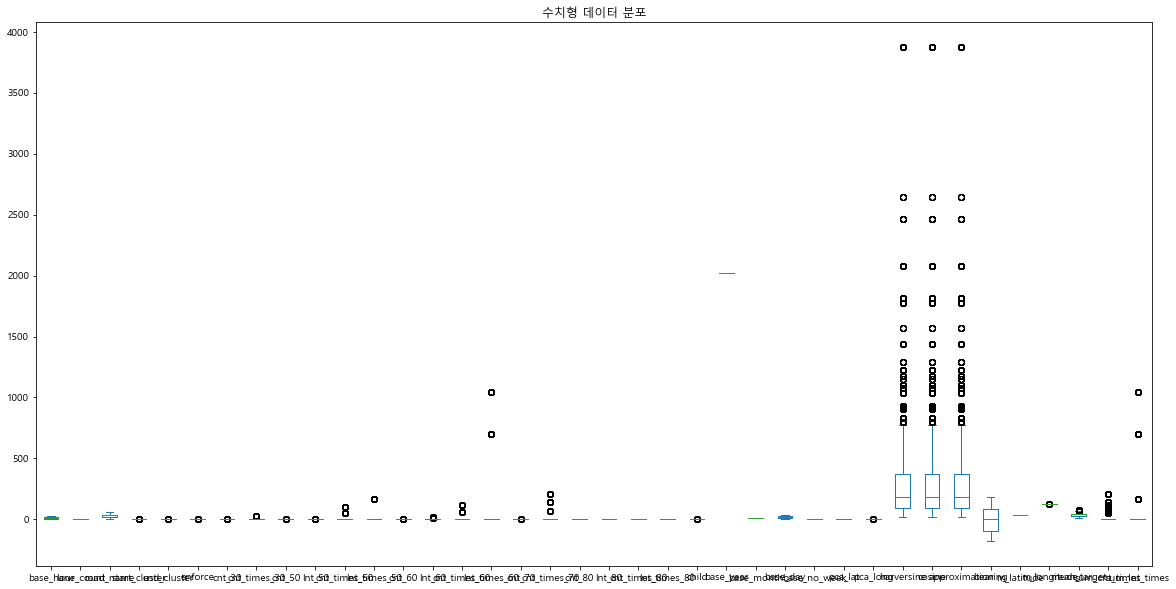

In [6]:
X_test.loc[:,num].plot.box(title="수치형 데이터 분포", figsize=(20,10))
plt.show()

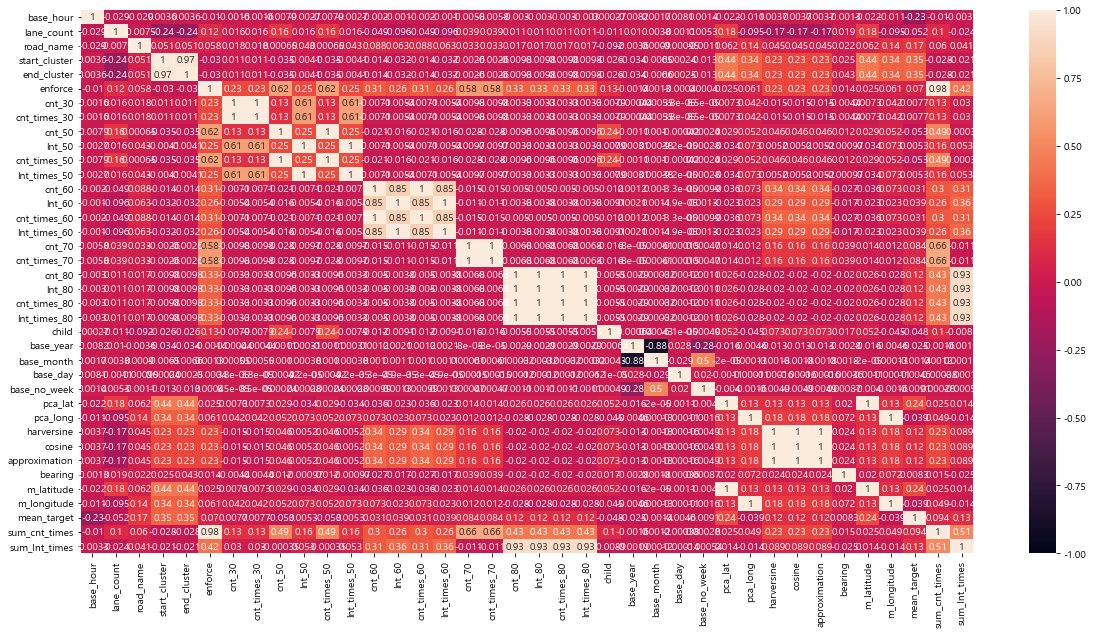

In [7]:
plt.figure(figsize=(20,10))
sns.heatmap(X_train.loc[:,num].corr(), annot=True, vmin=-1, vmax=1)
plt.show()

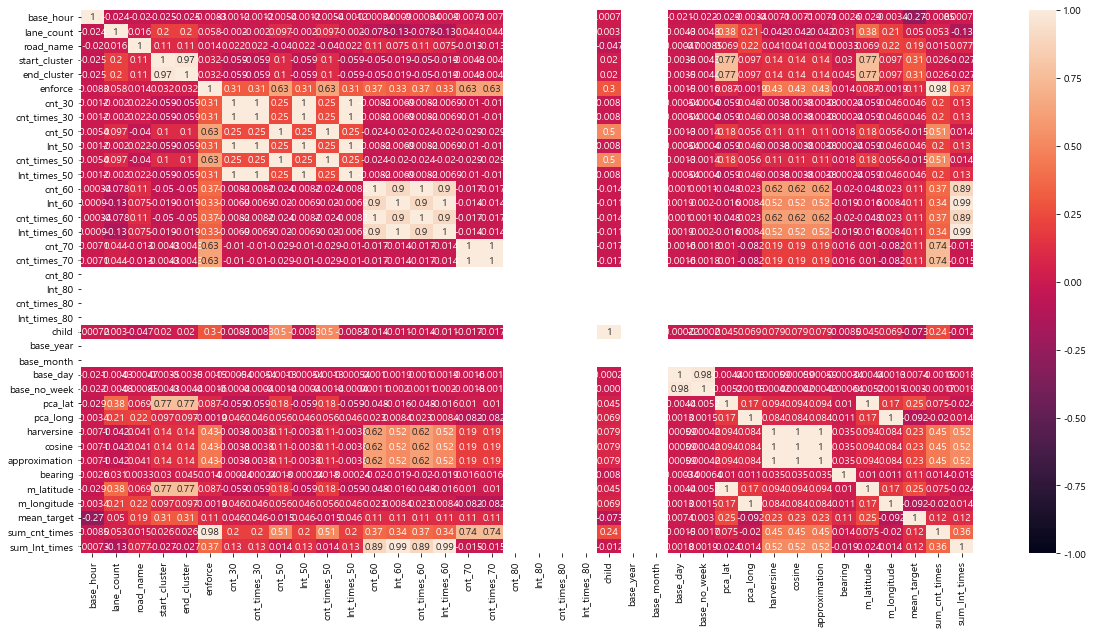

In [8]:
# base_year, base_month는 유용하지 못하다.
plt.figure(figsize=(20,10))
sns.heatmap(X_test.loc[:,num].corr(), annot=True, vmin=-1, vmax=1)
plt.show()

### $\blacktriangleright$ Feature Selection

- Split Data

In [32]:
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.3, random_state=2022)

- Train Base Model

In [33]:
model = LGBMRegressor(n_estimators=1000, metric= 'mae', random_state = 2022)

In [34]:
model.fit(train_X, train_y)

LGBMRegressor(metric='mae', n_estimators=1000, random_state=2022)

- Adjust Features

In [35]:
# 전체 47개 사용:  3.3203937773857057
# 상위 34개 사용:  3.3177121427457648
# 상위 32개 사용:  3.317685816818053, STOP
# 상위 29개 사용:  3.3207099888272595

print(f'상위 {X_train.shape[1]}개 사용: ',mean_absolute_error(val_y, model.predict(val_X)))

상위 29개 사용:  3.3207099888272595


In [36]:
# Feature Importance 확인
FI = pd.DataFrame({'Feature_Importances':model.feature_importances_})
display(FI.value_counts().sort_index())

Feature_Importances
24                     1
55                     1
61                     1
62                     1
63                     1
76                     1
100                    1
156                    1
179                    1
198                    1
202                    1
246                    1
288                    1
451                    1
484                    1
660                    1
673                    1
730                    1
762                    1
840                    1
911                    1
1031                   1
2052                   1
2217                   1
2898                   1
3001                   1
3139                   1
4213                   1
4228                   1
dtype: int64

In [31]:
# redefine features
# Log loss가 올라가는 importance 이면 그 사이값 재탐색 후 결정한다.
# limit = round(FI.value_counts().sort_index().index[1][0], 6)
# redefine_1 = FI.query('Feature_Importances > @limit').index
# redefine_2 = FI.query('Feature_Importances > @limit').index
# redefine_3 = FI.query('Feature_Importances > @limit').index

# X_train = X_train.iloc[:, redefine_3]
# X_test = X_test.iloc[:, redefine_3]

### Save Data

In [37]:
# 병합할 데이터를 가공한다.
train_id, test_id = train_raw['id'], test_raw['id']
del train_raw['id'], test_raw['id'], train_raw['target']

In [38]:
X_train = pd.concat([train_id, train_raw.iloc[:, redefine_1].iloc[:, redefine_2], y_train], axis=1)
X_test = pd.concat([test_id, test_raw.iloc[:,redefine_1].iloc[:, redefine_2]], axis=1)

In [39]:
# 삭제한 Column명을 확인한다.
set(train.columns) - set(X_train.columns)

{'approximation',
 'cnt_30',
 'cnt_80',
 'cnt_times_30',
 'cnt_times_50',
 'cnt_times_60',
 'cnt_times_70',
 'cnt_times_80',
 'cosine',
 'lnt_80',
 'lnt_times_50',
 'lnt_times_60',
 'lnt_times_80',
 'multi_linked',
 'sum_lnt_times'}

In [ ]:
sns.heatmap(X_train.corr(), annot=True, vmin=-1, vmax=1, cmap='Blues')
plt.show()

In [41]:
date = str(pd.Timestamp.now())[:10].replace('-','')
X_train.to_csv(f'../data/feature/{date}_train_select.csv', index=False)
X_test.to_csv(f'../data/feature/{date}_test_select.csv', index=False)